# Parallel processing of a stack of data stored in HDF5

This tutorial explains how it is possible to treat in parallel a large HDF5 dataset which does not fit into the computer memory.

For this tutorial, a very recent version of pyFAI is needed, newer then summer 2022. It demonstrates features wich will only be available in release 0.22.

This tutorial expains how to take benefit from Multithreading. This framework is not very popular in the Python world due to the GIL, but properly writted C-code which does release the GIL can be very fast, sometimes as fast as GPU code (on large computers).

Credits:

* Thomas Vincent (ESRF) for the parallel decompression of HDF5 chunks and the Jupyter-slurm
* Pierre Paleo (ESRF) for struggling with this kind of stuff with GPUs
* Jon Wright (ESRF) for the CSC integrator, while implemented in serial is multithreading friendly
* The French-CRG for providing a manycore computer (2 x 32-core AMD EPYC 75F3)

Nota: No GPU is needed for this tutorial !

In [1]:
import sys, os, collections, struct, time
import numpy, pyFAI
import h5py, hdf5plugin
from queue import Queue
import threading
import bitshuffle
import multiprocessing
start_time = time.time()
Item = collections.namedtuple("Item", "index data")
# Ensure OpenMP is disabled
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
nbthreads=multiprocessing.cpu_count()
print(f"Working with {nbthreads} threads but OpenMP needs to be disabled !")

Working with 16 threads but OpenMP needs to be disabled !


In [3]:
!lscpu

Architecture :                          x86_64
Mode(s) opératoire(s) des processeurs : 32-bit, 64-bit
Boutisme :                              Little Endian
Tailles des adresses:                   43 bits physical, 48 bits virtual
Processeur(s) :                         16
Liste de processeur(s) en ligne :       0-15
Thread(s) par cœur :                    2
Cœur(s) par socket :                    8
Socket(s) :                             1
Nœud(s) NUMA :                          1
Identifiant constructeur :              AuthenticAMD
Famille de processeur :                 23
Modèle :                                49
Nom de modèle :                         AMD EPYC 7262 8-Core Processor
Révision :                              0
Accroissement de fréquence :            activé
Vitesse du processeur en MHz :          1663.743
Vitesse maximale du processeur en MHz : 3400,0000
Vitesse minimale du processeur en MHz : 1500,0000
BogoMIPS :                              6400.02
Virtualisation :  

## Setup the enviroment:

This is a purely virtual experiment, we will use an Eiger 4M detector with data integrated over 1000 bins. Those parameters can be tuned.

Random data are generated, to keep this file fairly small, it is generated with small numbers which compress nicely. The speed of the drive where you will put the file is likely to have a huge impact !

In [4]:
det = pyFAI.detector_factory("eiger_4M")
shape = det.shape
dtype = numpy.dtype("uint32")
filename = "/tmp/big.h5"
nbins = 1000
cmp = hdf5plugin.Bitshuffle()
hdf5plugin.config

HDF5PluginBuildConfig(openmp=False, native=True, sse2=True, avx2=True, cpp11=True, filter_file_extension='.so', embedded_filters=('blosc', 'bshuf', 'bzip2', 'fcidecomp', 'lz4', 'zfp', 'zstd'))

In [5]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
print(f"Number of frames the computer can host in memory: {mem_bytes/(numpy.prod(shape)*dtype.itemsize):.3f}")
if os.environ.get('SLURM_MEM_PER_NODE'):
    print(f"Number of frames the computer can host in memory with SLURM restrictions: {int(os.environ['SLURM_MEM_PER_NODE'])*(1<<20)/(numpy.prod(shape)*dtype.itemsize):.3f}")

Number of frames the computer can host in memory: 3754.675


In [6]:
#The computer being limited to 64G of RAM, the number of frames actually possible is 3800.
nbframes = 4096 # slightly larger than the maximum achievable ! Such a dataset should not host in memory.

In [7]:
#Prepare a frame with little count so that it compresses well
frame = numpy.random.poisson(10, size=shape).astype(dtype)

In [8]:
%%timeit -r1 -n1 -o
with h5py.File(filename, "w") as h:
    ds = h.create_dataset("data", shape=(nbframes,)+shape, chunks=(1,)+shape, dtype=dtype, **cmp) 
    for i in range(nbframes):
        ds[i] = numpy.random.randint(0,10)+frame #Each frame a a different (random) value to prevent caching effects

1min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 1min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [9]:
timing_write = _
size=os.stat(filename).st_size
print(f"File size {size/(1024**3):.3f} GB with a compression ratio of {nbframes*numpy.prod(shape)*dtype.itemsize/size:.3f}x")
print(f"Write speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_write.best):.3f} MB/s of uncompressed data")

File size 11.082 GB with a compression ratio of 6.176x
Write speed: 1174.479 MB/s of uncompressed data


Reading all data from HDF5 file is as slow if not slower than the writing. This is mostly due to the decompression and to the many memory allocation performed.

In [10]:
%%timeit -r1 -n1 -o
#Reader
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])

57.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 57.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [11]:
timing_read1 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read1.best):.3f} MB/s of uncompressed data.")

Read speed: 1282.887 MB/s of uncompressed data.


In [12]:
def decompress_bslz4_chunk(payload, dtype, chunk_shape):
    """This function decompresses ONE chunk with bitshuffle-LZ4. 
    The library needs to be compiled without OpenMP when using threads !
    
    :param payload: string with the compressed data as read by h5py.
    :param dtype: data type of the stored content
    :param chunk_shape: shape of one chunk
    :return: decompressed chunk"""
    total_nbytes, block_nbytes = struct.unpack(">QI", payload[:12])
    block_size = block_nbytes // dtype.itemsize

    arr = numpy.frombuffer(payload, dtype=numpy.uint8, offset=12)  # No copy here
    chunk_data = bitshuffle.decompress_lz4(arr, chunk_shape, dtype, block_size)
    return chunk_data

In [13]:
%%timeit -r1 -n1 -o
chunk = None
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
        # decompress_bslz4_chunk(chunk, dtype, shape)

3.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 3.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [14]:
timing_read2 = _
print(f"Read speed: {size/(1e6*timing_read2.best):.3f} MB/s of compressed data.")
print(f"HDF5 read speed (without decompression): {nbframes/timing_read2.best:.3f} fps")

Read speed: 3879.348 MB/s of compressed data.
HDF5 read speed (without decompression): 1335.318 fps


But the reading part data is fairly fast, if one does not decompress the data.

In [15]:
#Decompression speed:
with h5py.File(filename, "r") as h:
    ds = h["data"]
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(1).chunk_offset)
print(filter_mask)
timing_decompress = %timeit -r3 -o decompress_bslz4_chunk(chunk, dtype, shape)
print(f"The maximum decompression speed is {1/timing_decompress.best:.3f} fps single threaded \nand could reach {nbthreads/timing_decompress.best:.3f} fps in parallel.")

0
16.5 ms ± 16 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
The maximum decompression speed is 60.567 fps single threaded 
and could reach 969.067 fps in parallel.


## Prepare the azimuthal integrator
To allow the full parallelization of different integrators working in parallel on must limit the number of Python call performed, this is why we need to extract the Cython integrator from AzimuthalIntegator. The integrator used here is a sparse matric multiplication one with a CSC representation which is single-threaded. This engine is usually not very fast but it is multitheading friendly as we will demonstrate.

In [16]:
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
omega = ai.solidAngleArray()
res0 = ai.integrate1d(frame, nbins, method=("full", "csc", "cython"))
engine = ai.engines[res0.method].engine
#This is how the engine works:
res1 = engine.integrate_ng(frame, solidangle=omega)
assert numpy.allclose(res0.intensity, res1.intensity)  # validates the equivalence of both approaches:
timing_integration = %timeit -r3 -o engine.integrate_ng(frame, solidangle=omega)
print(f"The maximum achievable integration speed on a single core is {1/timing_integration.best:.3f} fps which does not look fancy,\n\
but parallelized it could reach: {nbthreads/timing_integration.best:.3f} fps")

48.8 ms ± 47.9 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
The maximum achievable integration speed on a single core is 20.503 fps which does not look fancy,
but parallelized it could reach: 328.045 fps


In [17]:
%%timeit -o -r1 -n1
#Naive implementation ... read+integrate
result0 = numpy.zeros((nbframes, nbins), dtype=numpy.float32)
method = ("full", "csr", "cython")
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])
        result0[i] = ai.integrate1d(buffer, nbins, method=method).intensity

5min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 5min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [18]:
timing_naive = _
print(f"The maximum achievable decompression+integration speed is {1/(timing_decompress.best+timing_integration.best):.3f} fps in serial \n\
and {nbthreads*1/(timing_decompress.best+timing_integration.best):.3f} fps in parallel \n\
but a naive implementation provides only {nbframes/(timing_naive.best):.3f}  fps")

The maximum achievable decompression+integration speed is 15.318 fps in serial 
and 245.081 fps in parallel 
but a naive implementation provides only 12.174  fps


## Effective implementation using multithreading:
* One `reader` which reads the dataset chunk-by-chunk and makes them available via an input-queue, called `qin`
* A pool of `worker`s: pool of the size of the number of cores. Each `worker` is doing the decompression of one chunk into one frame and the azimuthal integration of that frame. The integrated result is put into an output-queue, called `qout`.
* 2 queues: `qin` and `qout`

The gathering of the data is performed in the main thread but it could also be in a separated thread.
Each piece of data is associated with its index in the dataset using the `Item` named-tuple.

Nota: I had a hard time to perform both reading and writing with HDF5 (even in different files). This is why the result is reconstructed in memory and the saving performed at the very end.

In [19]:
def worker(qin, qout):
    """Function representing one worker, used in a pool of worker.
    
    :param qin: input queue, expects Item with index and compressed chunk
    :param qout: output queue: puts item with index and integrated intensity
    :return: nothing, used in a thread.
    """
    while True:
        item = qin.get()
        index = item.index
        if index<0: 
            # print(threading.current_thread().name + " finished")
            qin.task_done()
            qout.put(item)
            return
        frame = decompress_bslz4_chunk(item.data, dtype, shape)
        qout.put(Item(index, engine.integrate_ng(frame, solidangle=omega).intensity))
        qin.task_done()

In [20]:
def reader(filename, h5path, queue, nbworkers):
    """Function reading the HDF5 file and enqueuing raw-chunks into the queue.
    Used in a thread.
    
    :param filename: name of the HDF5 file
    :param h5path: path to the dataset within the HDF5 file
    :param nbworker: number of worker to kill after the processing
    :return: nothing, used in a thread."""
    with h5py.File(filename, "r") as h:
        ds = h["data"]
        for i in range(ds.id.get_num_chunks()):
            filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
            if filter_mask==0:
                while queue.qsize()>1000:
                    #slow down to prevent filling up memory
                    time.sleep(0.1)
                queue.put(Item(i, chunk))
        # print(threading.current_thread().name + " finished")
        #kills all worker when done
        for i in range(nbworkers):
            queue.put(Item(-1, None))

In [21]:
def build_pool(nbthreads, qin, qout):
    """Build a pool of threads with workers"""
    pool = [threading.Thread(target=worker, name=f"worker_{i:02d}", args=(qin, qout)) for i in range(nbthreads)]
    for thread in pool:
        thread.start()
    return pool

def end_pool(pool):
    """Ends all threads from a pool by sending them a "kill-pill"""
    for thread in pool:
        qin.put(Item(-1, None))
        
#Small validation to check it works: 
qin = Queue()
qout = Queue()
pool=build_pool(4, qin, qout)
end_pool(pool)

This cell contains all the processing for a serial reader + parallel (decompression+integration)

In [22]:
%%timeit -o -r1 -n1
# This is where all the magic is assembled

# Define the two queues
qin = Queue()
qout = Queue()

# Build the pool of workers
pool=build_pool(nbthreads, qin, qout)
# And start the reader who immediately starts filling the qin.
threading.Thread(target=reader, name="reader", args=(filename, "data", qin, len(pool))).start()

#The main thread gathers the data in the `qout`
result = numpy.zeros((nbframes, nbins), dtype=numpy.float32)
remaining = len(pool) #Number of remaining active workers
while remaining:
    item = qout.get()
    index = item.index
    if index<0:
        remaining -=1
    else:
        result[index] = item.data
    qout.task_done()
        
# Finally ensure all tasks are done: this should be redundant with finished==len(pool)
qin.join()
qout.join()

30.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 30.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [23]:
timing_parallel = _
print(f"Effective throughput: {nbframes/timing_parallel.best:.3f} fps and \nspeed-up versus the naive version is {timing_naive.best/timing_parallel.best:0.3f}x for a computer with {nbthreads} threaads.")

Effective throughput: 134.684 fps and 
speed-up versus the naive version is 11.064x for a computer with 16 threaads.


One needs to replay the cell without the timeit to retrieve the results (timeit discards them!)

In [24]:
# Build the pool of workers
pool=build_pool(nbthreads, qin, qout)
# And start the reader who immediately starts filling the qin.
threading.Thread(target=reader, name="reader", args=(filename, "data", qin, len(pool))).start()

#The main thread gathers the data in the `qout`
result = numpy.zeros((nbframes, nbins), dtype=numpy.float32)
remaining = len(pool) #Number of remaining active workers
while remaining:
    item = qout.get()
    index = item.index
    if index<0:
        remaining -=1
    else:
        result[index] = item.data
    qout.task_done()
#Save the results
with h5py.File("results.h5", "w") as results:
    results.create_dataset("radial", data=res0.radial)
    results.create_dataset("integrated", data=result)

## Display some results
Since the input data were all synthetic and similar, no great science is expected from this... but one can ensure each frame differs slightly from the neighbors. 

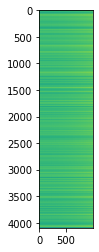

In [25]:
%matplotlib inline
from matplotlib.pyplot import subplots
fig,ax = subplots()
ax.imshow(result)

## Conclusion

Reading Bitshuffle-LZ4 data can be parallelized using multithreading in Python. 

The procedure is a bit tedious but not out of reach for a Python programmer: few threads and a couple of queues. 
This burden is worth when coupling decompression with azmuthal integration of the frame to reduce the amount of data to store in memory.

The performances obtained on a 64-core computer are close to what can be obtained from a GPU: 500 fps
The speed-up obtained with the procedure is 26x on a 64 core computer version single threaded implementation, which demonstrates multithreading is worth the burden. The speed-up is far from being 

Thanks again to the French-CRG for the computer.

In [26]:
print(f"Total processing time: {time.time()-start_time:.3f} s")

Total processing time: 537.061 s
